# NLP Disaster Tweets Kaggle Mini-Project

## Introduction 


I’ll walk you through my mini-project NLP Disaster Tweets Kaggle Mini-Project, where I participated in the Kaggle competition "Natural Language Processing with Disaster Tweets." My goal was to classify tweets as either reporting a disaster or not.

* **Data Format**: Each sample in the train and test sets contains:

    - The text of a tweet
    - A keyword from the tweet  
    - The location the tweet was sent from  

* **Task:** Predict if a tweet is a disaster or not

* **File Details**
    - train.csv: Contains the training set, including the target variable.
    - test.csv: Contains the test set.
    - sample_submission.csv: A sample file formatted for submissions.

* **Columns in the train dataset**:
      
    - id: Unique identifier for each tweet
    - text: The tweet's content
    - location: The tweet's sending location (may be blank)
    - keyword: A keyword from the tweet (may be blank)
    - target: Indicates if the tweet is about a real disaster (1) or not (0) in train.csv only.




## Imports

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn
import random
import os
train_on_gpu = True
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization, Input, Add, Dense, Activation, ZeroPadding2D, Flatten
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.models import Model, load_model
import tensorflow as tf
import pathlib
import tensorflow_io as tfio
from tensorflow.keras.optimizers import Adam
import seaborn as sns

## Exploratory Data Analysis (EDA)

* Let's load the dataset first 

In [3]:
train_path = "dataset/nlp-getting-started/train.csv"
test_path = "dataset/nlp-getting-started/test.csv"

data = pd.read_csv(train_path)

* Display basic information about the dataset

In [4]:
print("Dataset information:")
print(data.info())

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


* Display first few rows of the dataset

In [5]:
print("\nFirst few rows of the dataset:")
print(data.head())


First few rows of the dataset:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


* Summary statistics of numerical columns

In [6]:
print("\nSummary statistics of numerical columns:")
print(data.describe())



Summary statistics of numerical columns:
                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000


* It's time to check for missing values now

In [7]:
print("\nMissing values:")
print(data.isnull().sum())


Missing values:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


We can see above have some missing data in the location and keyword 

* Distribution of target variable

In [8]:
target_count = data['target'].value_counts()
print(target_count)
print("Imbalance ratio (0 to 1):", round(target_count[0]/(target_count[1]), 2))

target
0    4342
1    3271
Name: count, dtype: int64
Imbalance ratio (0 to 1): 1.33


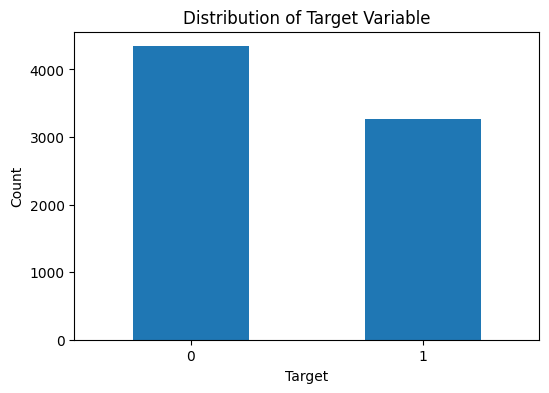

In [9]:

plt.figure(figsize=(6, 4))
data['target'].value_counts().plot(kind='bar')
plt.title("Distribution of Target Variable")
plt.xlabel("Target")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

We can see above that the targets aren't completly balanced, it's not that serious though, we can see the Imbalance ratio `(0 to 1)` is `1.33`

* Distribution of tweet lengths

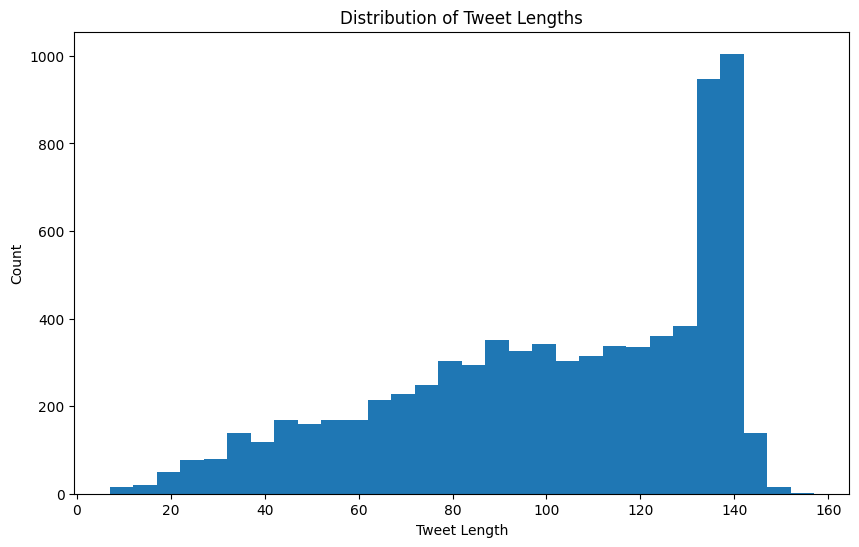

In [10]:
data['tweet_length'] = data['text'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(data['tweet_length'], bins=30)
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Tweet Length")
plt.ylabel("Count")
plt.show()

* Distribution of keyword occurrences


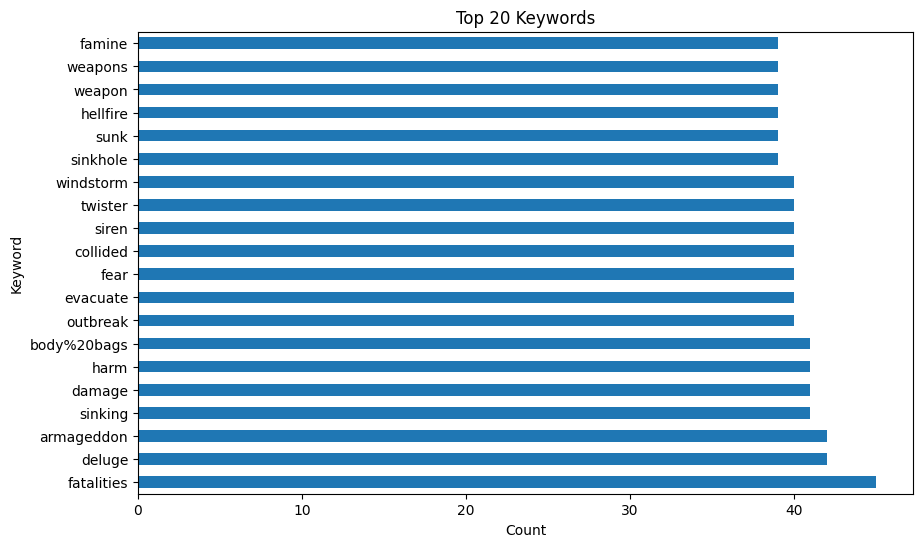

In [11]:
plt.figure(figsize=(10, 6))
data['keyword'].value_counts().head(20).plot(kind='barh')
plt.title("Top 20 Keywords")
plt.xlabel("Count")
plt.ylabel("Keyword")
plt.show()

* Distribution of locations


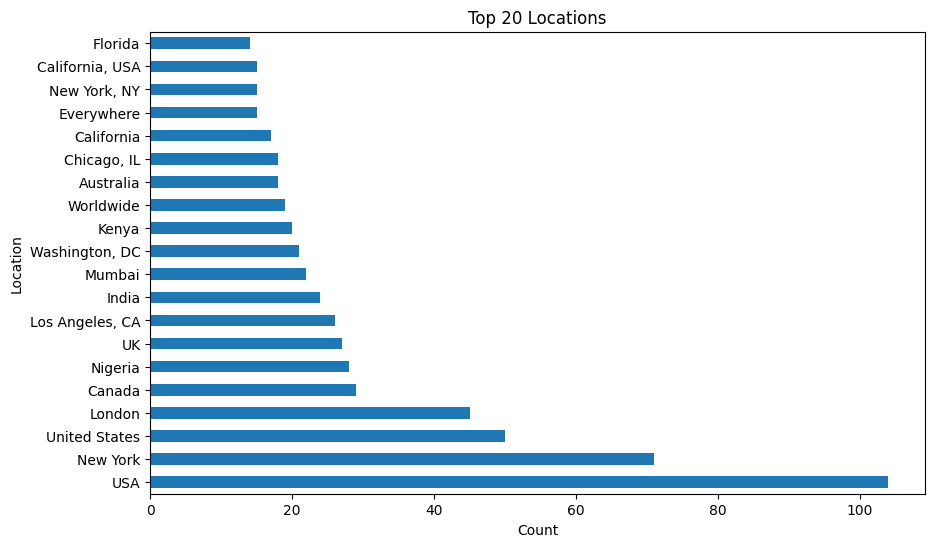

In [12]:
plt.figure(figsize=(10, 6))
data['location'].value_counts().head(20).plot(kind='barh')
plt.title("Top 20 Locations")
plt.xlabel("Count")
plt.ylabel("Location")
plt.show()

## Prepare the data

As seen above, we have **61** values missing for the `keyword` and **2533** for `location`, I will be filling up the missign data with NA


In [13]:
new_dataset = data = data.fillna('NA')
print("Missing values after filling with NaN:")
print(new_dataset.isnull().sum())

Missing values after filling with NaN:
id              0
keyword         0
location        0
text            0
target          0
tweet_length    0
dtype: int64


In [14]:
new_dataset.head()

,id,keyword,location,text,target,tweet_length
0,1,NA,NA,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NA,NA,Forest fire near La Ronge Sask. Canada,1,38
2,5,NA,NA,All residents asked to 'shelter in place' are ...,1,133
3,6,NA,NA,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NA,NA,Just got sent this photo from Ruby #Alaska as ...,1,88


Next, let's count the total number of words, this will become useful when creating the embedding layer

In [15]:
# Split each tweet into words and concatenate them into a single list
all_words = ' '.join(new_dataset['text']).split()

# Calculate the total number of unique words
unique_words = set(all_words)

print("Total number of unique words in the 'text' column:", len(unique_words))


Total number of unique words in the 'text' column: 31924


In [18]:
from sklearn.model_selection import train_test_split

# I'll first extract the text column and the target column only for now
X = data['text']
y = data['target']

# Split the data into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the datasets
print("Train dataset shape:", X_train.shape)
print("Validation dataset shape:", X_valid.shape)


Train dataset shape: (6090,)
Validation dataset shape: (1523,)


In [19]:
batch_size = 32

# Create TensorFlow datasets for train and validation sets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(len(X_train)).batch(batch_size)
valid_dataset = valid_dataset.batch(batch_size)

# Print a few examples from the datasets
for text, label in train_dataset.take(1):
    print(text)
    print(label)


tf.Tensor(
[b'catastrophic-fallen-angel: reveillertm: macabrelolita: I was supposed to write \xc2\x89\xc3\x9b\xc3\xb7amino acids\xc2\x89\xc3\x9b\xc2\xaa and I nearly... http://t.co/dIoBzGHFju'
 b"Hey #movietheatre mass murderer wanna-be we don't play that shit in the #615!"
 b'The X-rays in MKX be looking like fatalities.'
 b'Sassy city girl country hunk stranded in Smoky Mountain snowstorm #AoMS http://t.co/nkKcTttsD9 #ibooklove #bookboost'
 b"How to ruin the holidays in 3 wordk: 'It's a Zmne!'"
 b"I don't doubt it. But it was his implicit statement in doing it that makes me want him flattened by a bus. https://t.co/5hlJUcxI0S"
 b"@CounterMoonbat @Voodoo_Ben I've heard we're still using Purple Hearts manufactured then bc of the # of casualties we expected."
 b'@GeorgeFoster72 and The Wreck of the Edmund Fitzgerald'
 b"News: 'Islamic State claims suicide bombing at Saudi Arabian mosque' http://t.co/vIJfNHl630"
 b'What Natural Disaster Are You When You Get Angry? http://t.co/q4gl3Dvhu1'

2024-03-24 19:08:39.099636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Machine Learning Models

This step will create convert the trining sentences to lowercase and remove punctuations, then it splits the data based on 
white spaces and finally will sort the words by descending frequency to produce the most common 1000 words

This function will help in running the test set so I can submit it to Kaggle

The `run_test` function will do the following:

- Load the test data
- Extract the text column
- Create a TensorFlow dataset for the test set
- Create a submission DataFrame with ID and prediction
- And finally submit the `submission.csv` to Kaggle

In [20]:
def run_test(model):
    test_data = pd.read_csv(test_path)
    test_text = test_data['text']
    test_dataset = tf.data.Dataset.from_tensor_slices(test_text)
    test_dataset = test_dataset.batch(batch_size)
    threshold = 0.5 
    predictions = (model.predict(test_dataset) > threshold).astype(int)
    submission = pd.DataFrame({'id': test_data['id'], 'target': predictions.flatten()})
    submission.to_csv("submission.csv", index=False)


In [21]:
vocab_size = 1000
text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size)
text_vec_layer.adapt(train_dataset.map(lambda text, target: text))

2024-03-24 19:08:45.628890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Will try running the following model 

In [23]:
embed_size = 128

# Define the model architecture
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# I'll add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=20, callbacks=[early_stopping])

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(valid_dataset)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


Epoch 1/20


2024-03-24 19:09:29.105729: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8904


191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5761 - loss: 0.6839 - val_accuracy: 0.5791 - val_loss: 0.6791
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7171 - loss: 0.5685 - val_accuracy: 0.7840 - val_loss: 0.4684
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8192 - loss: 0.4335 - val_accuracy: 0.7938 - val_loss: 0.4744
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8431 - loss: 0.3832 - val_accuracy: 0.7932 - val_loss: 0.4676
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8447 - loss: 0.3767 - val_accuracy: 0.7945 - val_loss: 0.4957
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8628 - loss: 0.3422 - val_accuracy: 0.7833 - val_loss: 0.4967
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8765 - loss: 0.3152 - val_accuracy: 0.7873 - val_loss: 0.5423
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7887 - loss: 0.4842
Validation Loss: 0.4675739109516144
Valida

In [118]:
run_test(model)

102/102 [==============================] - 1s 3ms/step


This got ~79% accuracy using the validation set, I'll try makeing the model simpler by removing some layers

In [113]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
text_vec_layer,
tf.keras.layers.Embedding(vocab_size, embed_size),
tf.keras.layers.GRU(128),
tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
metrics=["accuracy"])
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=20)

Epoch 1/20
191/191 [==============================] - 8s 35ms/step - loss: 0.6444 - accuracy: 0.6167 - val_loss: 0.4813 - val_accuracy: 0.7787
Epoch 2/20
191/191 [==============================] - 2s 11ms/step - loss: 0.4430 - accuracy: 0.8056 - val_loss: 0.4724 - val_accuracy: 0.7945
Epoch 3/20
191/191 [==============================] - 1s 7ms/step - loss: 0.4029 - accuracy: 0.8278 - val_loss: 0.4702 - val_accuracy: 0.7905
Epoch 4/20
191/191 [==============================] - 1s 6ms/step - loss: 0.3803 - accuracy: 0.8373 - val_loss: 0.4704 - val_accuracy: 0.7945
Epoch 5/20
191/191 [==============================] - 1s 6ms/step - loss: 0.3653 - accuracy: 0.8524 - val_loss: 0.5063 - val_accuracy: 0.7932
Epoch 6/20
191/191 [==============================] - 1s 6ms/step - loss: 0.3433 - accuracy: 0.8622 - val_loss: 0.4887 - val_accuracy: 0.7886
Epoch 7/20
191/191 [==============================] - 1s 6ms/step - loss: 0.3243 - accuracy: 0.8734 - val_loss: 0.5146 - val_accuracy: 0.7814
Epoc

As you can see above the model started performing better bet then got worse, I'll try with 2 epochs only

In [123]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
text_vec_layer,
tf.keras.layers.Embedding(vocab_size, embed_size),
tf.keras.layers.GRU(128),
tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
metrics=["accuracy"])
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=2)

Epoch 1/2
191/191 [==============================] - 8s 32ms/step - loss: 0.6544 - accuracy: 0.6053 - val_loss: 0.5026 - val_accuracy: 0.7689
Epoch 2/2
191/191 [==============================] - 2s 11ms/step - loss: 0.4532 - accuracy: 0.7956 - val_loss: 0.4671 - val_accuracy: 0.7925


Submitting the `submission.csv` got me `0.79803`, next I'll modify the model and try to see if I can a better score

First I'll increase the number of epochs and see if that alone helps

In [122]:
run_test(model)

102/102 [==============================] - 0s 2ms/step


As you can see above, the simpler model, is doing much better that the complicated one.

## Kaggle Score

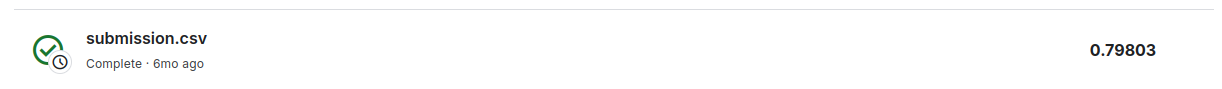

In [3]:
from IPython.display import Image
Image(filename='kaggle-score.png') 


## Conclusion and Future Enhancements


In this project, I ran sentiment analysis within the context of the Kaggle competition "Natural Language Processing with Disaster Tweets." 

My objective was to decide whether a tweet is of a disaster or not. 

I started by partitioning the tweet dataset into training and validation sets, using Scikit-learn for this task. Subsequently, I prepared the text data for TensorFlow utilization, utilizing the TextVectorization layer. 

I've seen a minor issue due to datatype disparities, I was able to resolv it by converting the integer representations to strings. Following data preparation, I experimented with different model configurations and found success with a relatively simple architecture consisting of an embedding layer, a GRU layer, and a dense layer for prediction. 

This model provided me with the best performance, achieving highest accuracy on both training and validation data.

**Future Enhancements:**

To enhance the model accuracy even more, the following can be applied:

- Feature Engineering: Add additional dataset features like tweet length, hashtags, or time of posting.

- Advanced Text Processing: Experiment with techniques like stemming, lemmatization, or part-of-speech tagging for better text representation.

- Optimize Model Architecture: Fine-tune hyperparameters, try different layers (e.g., LSTM), or use dropout regularization to prevent overfitting.

- Transfer Learning: Utilize pre-trained language models like BERT or GPT and fine-tune them for tweet classification.

- Data Augmentation: Generate synthetic examples to increase training data diversity and improve model generalization.

- Hyperparameter Tuning: Systematically search for optimal hyperparameters using methods like grid search or random search.

## References:

https://www.kaggle.com/competitions/nlp-getting-started/overview


## Citation
Addison Howard, devrishi, Phil Culliton, Yufeng Guo. (2019). Natural Language Processing with Disaster Tweets. Kaggle. https://kaggle.com/competitions/nlp-getting-started